## Part 2: Classifying and Analysing Cloud Images

### Library Import

In [1]:
import os
import json
import tensorflow as tf
import albumentations as albu
import cv2
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.optimizers import Adam, Nadam
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import segmentation_models as sm

C:\Users\maila\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\maila\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\maila\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\maila\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

Segmentation Models: using `keras` framework.


### Data loading and Formatting

In [2]:
df = pd.read_csv('train.csv')

In [3]:
train_df = df[0:15000]
test_df = pd.read_csv('cyclone_data.csv')
train_df['ImageId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[0])
train_df['ClassId'] = train_df['Image_Label'].apply(lambda x: x.split('_')[1])
train_df['MaskPresent'] = ~ train_df['EncodedPixels'].isna()

C:\Users\maila\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\maila\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\maila\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [4]:
mask_df = train_df.groupby('ImageId').agg(np.sum).reset_index()
mask_df.sort_values('MaskPresent', ascending=False, inplace=True)
print(mask_df.shape)
mask_df.head()

(3750, 2)


,ImageId,MaskPresent
2530,734305a.jpg,4.0
3204,9219fe4.jpg,4.0
3556,a26c013.jpg,4.0
2828,80c5371.jpg,4.0
1675,4d7ab3d.jpg,4.0


In [5]:
test_df['ImageId'] = test_df['Image_Label'].apply(lambda x: x.split('_')[0])
test_imgs = pd.DataFrame(test_df['ImageId'].unique(), columns=['ImageId'])

### Defining Utility Functions

In [6]:
def np_resize(img, input_shape):
    height, width = input_shape
    return cv2.resize(img, (width, height))

In [7]:
def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [8]:
def rle2mask(rle, input_shape):
    width, height = input_shape[:2]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return mask.reshape(height, width).T

In [9]:
def build_masks(rles, input_shape, reshape=None):
    depth = len(rles)
    if reshape is None:
        masks = np.zeros((*input_shape, depth))
    else:
        masks = np.zeros((*reshape, depth))
    
    for i, rle in enumerate(rles):
        if type(rle) is str:
            if reshape is None:
                masks[:, :, i] = rle2mask(rle, input_shape)
            else:
                mask = rle2mask(rle, input_shape)
                reshaped_mask = np_resize(mask, reshape)
                masks[:, :, i] = reshaped_mask
    
    return masks

In [10]:
def build_rles(masks, reshape=None):
    width, height, depth = masks.shape
    
    rles = []
    
    for i in range(depth):
        mask = masks[:, :, i]
        
        if reshape:
            mask = mask.astype(np.float32)
            mask = np_resize(mask, reshape).astype(np.int64)
        
        rle = mask2rle(mask)
        rles.append(rle)
        
    return rles

In [11]:
#RAdam
class RAdam(keras.optimizers.Optimizer):
    

    def __init__(self, lr=0.001, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0., weight_decay=0., amsgrad=False,
                 total_steps=0, warmup_proportion=0.1, min_lr=0., **kwargs):
        super(RAdam, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
            self.weight_decay = K.variable(weight_decay, name='weight_decay')
            self.total_steps = K.variable(total_steps, name='total_steps')
            self.warmup_proportion = K.variable(warmup_proportion, name='warmup_proportion')
            self.min_lr = K.variable(min_lr, name='min_lr')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.initial_weight_decay = weight_decay
        self.initial_total_steps = total_steps
        self.amsgrad = amsgrad

    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr

        if self.initial_decay > 0:
            lr = lr * (1. / (1. + self.decay * K.cast(self.iterations, K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1

        if self.initial_total_steps > 0:
            warmup_steps = self.total_steps * self.warmup_proportion
            lr = K.switch(
                t <= warmup_steps,
                lr * (t / warmup_steps),
                self.min_lr + (lr - self.min_lr) * (1.0 - K.minimum(t, self.total_steps) / self.total_steps),
            )

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='m_' + str(i)) for (i, p) in enumerate(params)]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='v_' + str(i)) for (i, p) in enumerate(params)]

        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p), name='vhat_' + str(i)) for (i, p) in enumerate(params)]
        else:
            vhats = [K.zeros(1, name='vhat_' + str(i)) for i in range(len(params))]

        self.weights = [self.iterations] + ms + vs + vhats

        beta_1_t = K.pow(self.beta_1, t)
        beta_2_t = K.pow(self.beta_2, t)

        sma_inf = 2.0 / (1.0 - self.beta_2) - 1.0
        sma_t = sma_inf - 2.0 * t * beta_2_t / (1.0 - beta_2_t)

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)

            m_corr_t = m_t / (1.0 - beta_1_t)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                v_corr_t = K.sqrt(vhat_t / (1.0 - beta_2_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                v_corr_t = K.sqrt(v_t / (1.0 - beta_2_t) + self.epsilon)

            r_t = K.sqrt((sma_t - 4.0) / (sma_inf - 4.0) *
                         (sma_t - 2.0) / (sma_inf - 2.0) *
                         sma_inf / sma_t)

            p_t = K.switch(sma_t >= 5, r_t * m_corr_t / v_corr_t, m_corr_t)

            if self.initial_weight_decay > 0:
                p_t += self.weight_decay * p

            p_t = p - lr * p_t

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {
            'lr': float(K.get_value(self.lr)),
            'beta_1': float(K.get_value(self.beta_1)),
            'beta_2': float(K.get_value(self.beta_2)),
            'decay': float(K.get_value(self.decay)),
            'weight_decay': float(K.get_value(self.weight_decay)),
            'epsilon': self.epsilon,
            'amsgrad': self.amsgrad,
            'total_steps': float(K.get_value(self.total_steps)),
            'warmup_proportion': float(K.get_value(self.warmup_proportion)),
            'min_lr': float(K.get_value(self.min_lr)),
        }
        base_config = super(RAdam, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [12]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

### Data Generator

In [13]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, df, target_df=None, mode='fit',
                 base_path='irma',
                 batch_size=32, dim=(1600,1600), n_channels=3, reshape=None,
                 augment=False, n_classes=4, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.mode = mode
        self.base_path = base_path
        self.target_df = target_df
        self.list_IDs = list_IDs
        self.reshape = reshape
        self.n_channels = n_channels
        self.augment = augment
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.random_state = random_state
        
        self.on_epoch_end()
        np.random.seed(self.random_state)

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_batch = [self.list_IDs[k] for k in indexes]
        
        X = self.__generate_X(list_IDs_batch)
        
        if self.mode == 'fit':
            y = self.__generate_y(list_IDs_batch)
            
            if self.augment:
                X, y = self.__augment_batch(X, y)
            
            return X, y
        
        elif self.mode == 'predict':
            return X

        else:
            raise AttributeError('The mode parameter should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, list_IDs_batch):
        'Generates data containing batch_size samples'
        # Initialization
        if self.reshape is None:
            X = np.empty((self.batch_size, *self.dim, self.n_channels))
        else:
            X = np.empty((self.batch_size, *self.reshape, self.n_channels))
        
        # Generate data
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            img_path = f"{self.base_path}/{im_name}.jpg"
            img = self.__load_rgb(img_path)
            
            if self.reshape is not None:
                img = np_resize(img, self.reshape)
            
            # Store samples
            X[i,] = img

        return X
    
    def __generate_y(self, list_IDs_batch):
        if self.reshape is None:
            y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=int)
        else:
            y = np.empty((self.batch_size, *self.reshape, self.n_classes), dtype=int)
        
        for i, ID in enumerate(list_IDs_batch):
            im_name = self.df['ImageId'].iloc[ID]
            image_df = self.target_df[self.target_df['ImageId'] == im_name]
            
            rles = image_df['EncodedPixels'].values
            
            if self.reshape is not None:
                masks = build_masks(rles, input_shape=self.dim, reshape=self.reshape)
            else:
                masks = build_masks(rles, input_shape=self.dim)
            
            y[i, ] = masks

        return y
    
    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img.astype(np.float32) / 255.
        img = np.expand_dims(img, axis=-1)

        return img
    
    def __load_rgb(self, img_path):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.

        return img
    
    def __random_transform(self, img, masks):
        composition = albu.Compose([
            albu.HorizontalFlip(),
            albu.VerticalFlip(),
            albu.ShiftScaleRotate(rotate_limit=45, shift_limit=0.15, scale_limit=0.15)
        ])
        
        composed = composition(image=img, mask=masks)
        aug_img = composed['image']
        aug_masks = composed['mask']
        
        return aug_img, aug_masks
    
    def __augment_batch(self, img_batch, masks_batch):
        for i in range(img_batch.shape[0]):
            img_batch[i, ], masks_batch[i, ] = self.__random_transform(
                img_batch[i, ], masks_batch[i, ])
        
        return img_batch, masks_batch

### Deep Learning

In [14]:
def vanilla_unet(input_shape):
   
    inputs = Input(input_shape)

    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2), padding='same') (c1)

    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2), padding='same') (c2)

    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2), padding='same') (c3)

    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
    p4 = MaxPooling2D((2, 2), padding='same') (c4)

    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
    p5 = MaxPooling2D((2, 2), padding='same') (c5)

    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)

    outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [15]:
model = sm.Unet(
    'resnet34', 
    classes=4,
    input_shape=(320, 480, 3),
    activation='sigmoid'
)
model.compile(optimizer=Nadam(lr=0.0002), loss=bce_dice_loss, metrics=[dice_coef])
model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 320, 480, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 320, 480, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 486, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 160, 240, 64) 9408        zero_padding2d_1[0][0]         

In [16]:
import keras.losses
keras.losses.custom_loss = bce_dice_loss
model.load_weights(os.path.join('model.h5'))

In [17]:
test_df_1 = []

for i in range(0, test_imgs.shape[0], 500):
    batch_idx = list(
        range(i, min(test_imgs.shape[0], i + 500))
    )

    test_generator = DataGenerator(
        batch_idx,
        df=test_imgs,
        shuffle=False,
        mode='predict',
        dim=(1600,1600),
        reshape=(320, 480),
        n_channels=3,
        base_path='cyclone_images',
        target_df=test_df,
        batch_size=1,
        n_classes=4
    )

    batch_pred_masks = model.predict_generator(
        test_generator, 
        workers=1,
        verbose=1
    )

    for j, b in enumerate(batch_idx):
        filename = test_imgs['ImageId'].iloc[b]
        image_df = test_df[test_df['ImageId'] == filename].copy()

        pred_masks = batch_pred_masks[j, ].round().astype(int)
        pred_rles = build_rles(pred_masks, reshape=(350, 525))

        image_df['EncodedPixels'] = pred_rles
        test_df_1.append(image_df)


18/18 [==============================] - 21s 1s/step


In [18]:
cyclone_df = pd.concat(test_df_1)

In [19]:
cyclone_df = cyclone_df.replace(r'^\s*$', np.nan, regex=True)

In [20]:
cyclone_df = cyclone_df[~cyclone_df['EncodedPixels'].isnull()]
cyclone_df['Image'] = cyclone_df['Image_Label'].map(lambda x: x.split('_')[0])
cyclone_df['Class'] = cyclone_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = cyclone_df['Class'].unique()
cyclone_df = cyclone_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    cyclone_df[class_name] = cyclone_df['Class'].map(lambda x: 1 if class_name in x else 0)

In [21]:
cyclone_df

,Image,Class,gravel,sugar,fish
0,dorian090919,"{sugar, gravel}",1,1,0
1,dorian100919,"{sugar, gravel}",1,1,0
2,dorian110919,"{sugar, gravel}",1,1,0
3,dorian210819,"{sugar, gravel}",1,1,0
4,dorian220819,"{sugar, gravel}",1,1,0
5,dorian230819,"{fish, gravel}",1,0,1
6,irma120917,{gravel},1,0,0
7,irma130917,"{sugar, gravel}",1,1,0
8,irma140917,{gravel},1,0,0
9,irma290817,"{fish, gravel, sugar}",1,1,1


### Visualisations

#### Visualising the training dataset

In [22]:
train_df = train_df[~train_df['EncodedPixels'].isnull()]
train_df['Image'] = train_df['Image_Label'].map(lambda x: x.split('_')[0])
train_df['Class'] = train_df['Image_Label'].map(lambda x: x.split('_')[1])
classes = train_df['Class'].unique()
train_df = train_df.groupby('Image')['Class'].agg(set).reset_index()
for class_name in classes:
    train_df[class_name] = train_df['Class'].map(lambda x: 1 if class_name in x else 0)

In [23]:
train_df

,Image,Class,Fish,Flower,Sugar,Gravel
0,0011165.jpg,"{Fish, Flower}",1,1,0,0
1,002be4f.jpg,"{Sugar, Fish, Flower}",1,1,1,0
2,0031ae9.jpg,"{Sugar, Fish, Flower}",1,1,1,0
3,0035239.jpg,"{Gravel, Flower}",0,1,0,1
4,003994e.jpg,"{Fish, Sugar, Gravel}",1,0,1,1
...,...,...,...,...,...,...
3745,ab3cba9.jpg,{Flower},0,1,0,0
3746,ab41d16.jpg,"{Fish, Gravel}",1,0,0,1
3747,ab48e9a.jpg,"{Gravel, Sugar}",0,0,1,1
3748,ab52d24.jpg,"{Gravel, Sugar}",0,0,1,1


#### Histogram

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Prevalance Fish type clouds in training data')

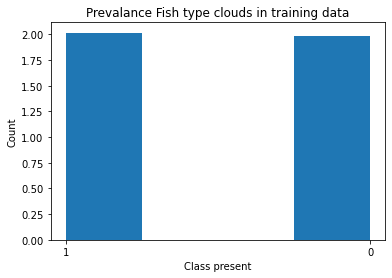

In [25]:
plt.hist(train_df['Fish'].astype(str),density=True,bins=4)
plt.ylabel('Count')
plt.xlabel('Class present')
plt.title('Prevalance Fish type clouds in training data')

Text(0.5, 1.0, 'Prevalance Fish type clouds in cyclone data')

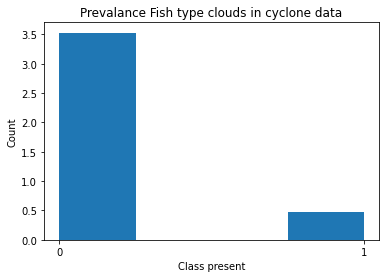

In [26]:
plt.hist(cyclone_df['fish'].astype(str),density=True,bins=4)
plt.ylabel('Count')
plt.xlabel('Class present')
plt.title('Prevalance Fish type clouds in cyclone data')

Text(0.5, 1.0, 'Prevalance Sugar type clouds in training data')

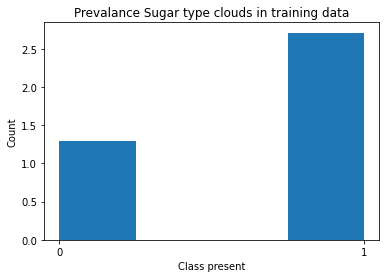

In [27]:
plt.hist(train_df['Sugar'].astype(str),density=True,bins=4)
plt.ylabel('Count')
plt.xlabel('Class present')
plt.title('Prevalance Sugar type clouds in training data')

Text(0.5, 1.0, 'Prevalance Sugar type clouds in cyclone data')

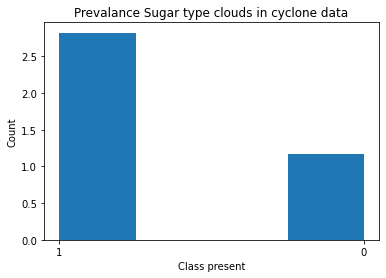

In [28]:
plt.hist(cyclone_df['sugar'].astype(str),density=True,bins=4)
plt.ylabel('Count')
plt.xlabel('Class present')
plt.title('Prevalance Sugar type clouds in cyclone data')

Text(0.5, 1.0, 'Prevalance Gravel type clouds in training data')

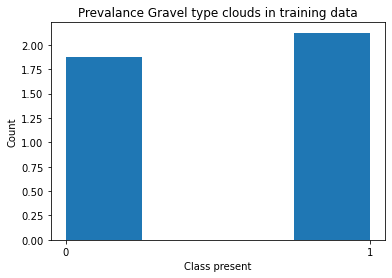

In [29]:
plt.hist(train_df['Gravel'].astype(str),density=True,bins=4)
plt.ylabel('Count')
plt.xlabel('Class present')
plt.title('Prevalance Gravel type clouds in training data')

Text(0.5, 1.0, 'Prevalance Gravel type clouds in cyclone data')

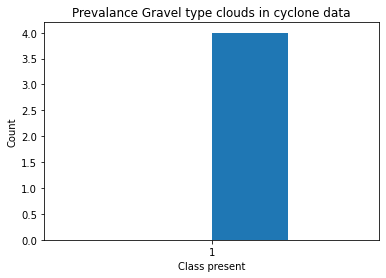

In [30]:
plt.hist(cyclone_df['gravel'].astype(str),density=True,bins=4)
plt.ylabel('Count')
plt.xlabel('Class present')
plt.title('Prevalance Gravel type clouds in cyclone data')

Text(0.5, 1.0, 'Prevalance Flower type clouds in training data')

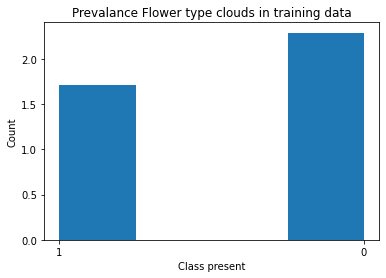

In [31]:
plt.hist(train_df['Flower'].astype(str),density=True,bins=4)
plt.ylabel('Count')
plt.xlabel('Class present')
plt.title('Prevalance Flower type clouds in training data')

#### Pie Chart

In [32]:
# Creating the variables
fish_sum_tr = np.sum(train_df.Fish)
flower_sum_tr = np.sum(train_df.Flower)
sugar_sum_tr = np.sum(train_df.Sugar)
gravel_sum_tr = np.sum(train_df.Gravel)

tr_data = [fish_sum_tr,flower_sum_tr,sugar_sum_tr,gravel_sum_tr]
tr_labels = ['Fish','Flower','Sugar','Gravel']

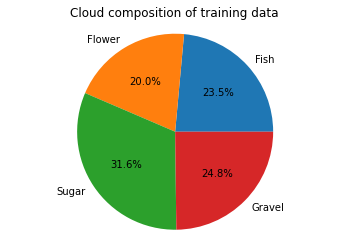

In [33]:
plt.pie(tr_data,labels=tr_labels,autopct='%1.1f%%')
plt.title('Cloud composition of training data')
plt.axis('equal')
plt.show()

In [34]:
# Creating the variables
fish_sum_cy = np.sum(cyclone_df.fish)
sugar_sum_cy = np.sum(cyclone_df.sugar)
gravel_sum_cy = np.sum(cyclone_df.gravel)

cy_data = [fish_sum_cy,sugar_sum_cy,gravel_sum_cy]
cy_labels = ['Fish','Sugar','Gravel']

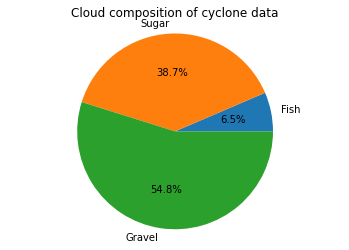

In [35]:
plt.pie(cy_data,labels=cy_labels,autopct='%1.1f%%')
plt.title('Cloud composition of cyclone data')
plt.axis('equal')
plt.show()

### Composition of clouds during and after cyclones

In [36]:
date = []
for i in cyclone_df.Image:
    date.append(i[-6:-4]+'-'+i[-4:-2]+'-'+i[-2:])

In [37]:
cyclone_df['Date'] = date
cyclone_df = cyclone_df.set_index('Date')

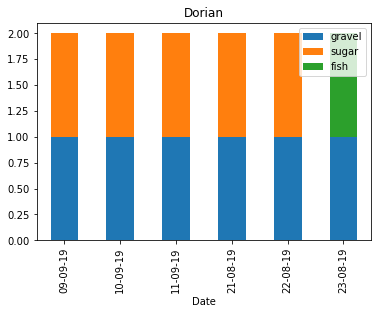

In [38]:
cyclone_df[0:6].plot(kind='bar', stacked=True, title = 'Dorian')

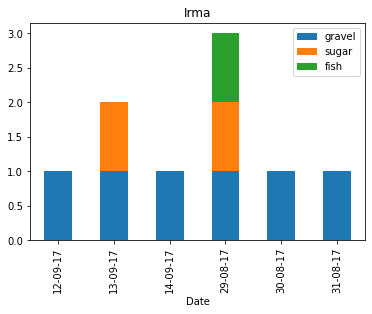

In [39]:
cyclone_df[6:12].plot(kind='bar', stacked=True, title ='Irma')

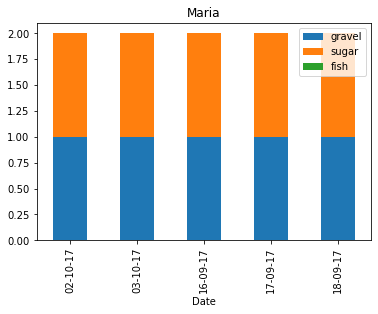

In [40]:
cyclone_df[12:18].plot(kind='bar', stacked=True, title ='Maria')

In [41]:
cyclone_df

,Image,Class,gravel,sugar,fish
Date,,,,,
09-09-19,dorian090919,"{sugar, gravel}",1,1,0
10-09-19,dorian100919,"{sugar, gravel}",1,1,0
11-09-19,dorian110919,"{sugar, gravel}",1,1,0
21-08-19,dorian210819,"{sugar, gravel}",1,1,0
22-08-19,dorian220819,"{sugar, gravel}",1,1,0
23-08-19,dorian230819,"{fish, gravel}",1,0,1
12-09-17,irma120917,{gravel},1,0,0
13-09-17,irma130917,"{sugar, gravel}",1,1,0
14-09-17,irma140917,{gravel},1,0,0
